#**Description**
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

**Problem Statement**
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>**Useful Links**
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30





In [146]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import distance
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import spacy

In [93]:
!pip install fuzzywuzzy

In [96]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [98]:
!pip install distance

     |████████████████████████████████| 180 kB 11.9 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=19bf41e156297d3afd63b85a3f9dc9f834eb9785b2e73f8af39f0633080d9ac7
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [3]:
%cd /content/drive/MyDrive/Quora

/content/drive/MyDrive/Quora


In [63]:
df=pd.read_csv('/content/drive/MyDrive/Quora/quora.csv')

In [5]:
print('no. of columns: ', df.shape[1])
print('no. of rows: ', df.shape[0])

no. of columns:  6
no. of rows:  404290


In [6]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


question1 column has 1 and question2 column has 2 NULL values and rest are non-null values

63.1% pairs of questions have is_duplicate = 1
36.9% pairs of questions have is_duplicate = 0


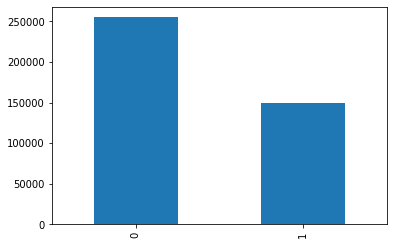

In [14]:
df.is_duplicate.value_counts().plot.bar()
print("{}% pairs of questions have is_duplicate = 1".format(round(100-df.is_duplicate.mean()*100,1)))
print("{}% pairs of questions have is_duplicate = 0".format(round(df.is_duplicate.mean()*100,1)))

In [38]:
total_qid=pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qid=len(total_qid.unique())
unique_morethanonce=np.sum(total_qid.value_counts()>1)
repeated_max=max(total_qid.value_counts())
print("NO. of unique questions = {}".format(unique_qid))
print("Questions which appeared more than once = {} ({}% of total uniques)".format(unique_morethanonce,round(unique_morethanonce/unique_qid*100,1)))
print("Max no of times that a question repeated = {}".format(repeated_max))

NO. of unique questions = 537933
Questions which appeared more than once = 111780 (20.8% of total uniques)
Max no of times that a question repeated = 157


In [48]:
dup_pair=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count()
print("no of duplicate question pair = ",df.shape[0]-dup_pair.shape[0])

no of duplicate question pair =  0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



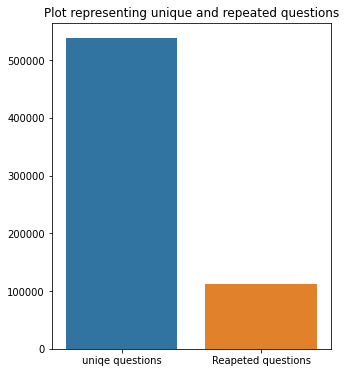

In [51]:
x=['uniqe questions','Reapeted questions']
y=[unique_qid,unique_morethanonce]

plt.figure(figsize=(5,6))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

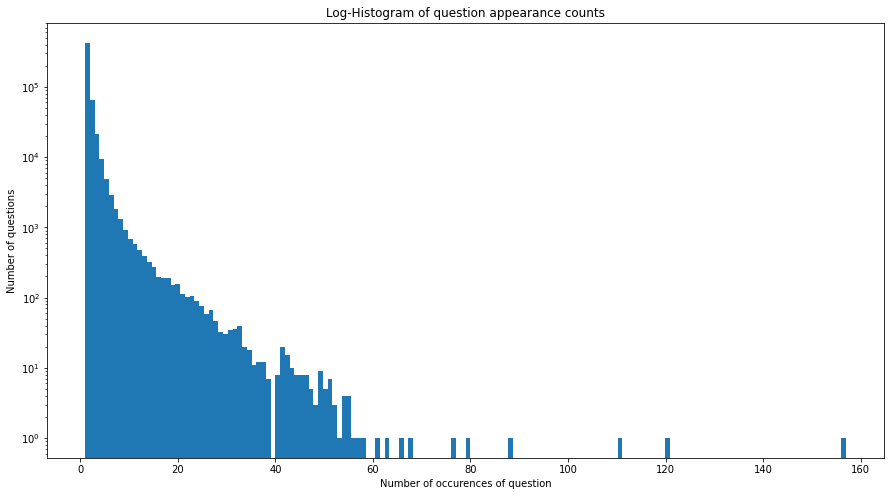

In [55]:
plt.figure(figsize=(15, 8))
plt.hist(total_qid.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

## **Removing NaN**

In [67]:
nans=df[df.isnull().any(axis=1)]
nans

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [68]:
df=df.fillna(" ")       #replace NaNs with space
nans=df[df.isnull().any(axis=1)]
print(nans)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## **Basic Feature Extraction**

Let us now construct some new features:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [77]:
if os.path.isfile('df_features_without_preprocessing.csv'):
  df=pd.read_csv('df_features_without_preprocessing.csv')
else:
  df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
  df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
  df['q1len']=df['question1'].str.len()
  df['q2len']=df['question2'].str.len()
  df['q1_n_words']=df['question1'].apply(lambda row:len(row.split(" ")))
  df['q2_n_words']=df['question2'].apply(lambda row:len(row.split(" ")))

  def cw(row):
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
  df['word_common']=df.apply(cw,axis=1)

  def wt(row):
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return 1.0 * (len(w1)+len(w2))
  df['word_Total']=df.apply(wt,axis=1)

  def ws(row):
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return 1.0 * (len(w1 & w2)/(len(w1)+len(w2)))
  df['word_share']=df.apply(ws,axis=1)

  df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
  df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

  df.to_csv("df_features_without_preprocessing.csv",index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [78]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


**Feature: word_share**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



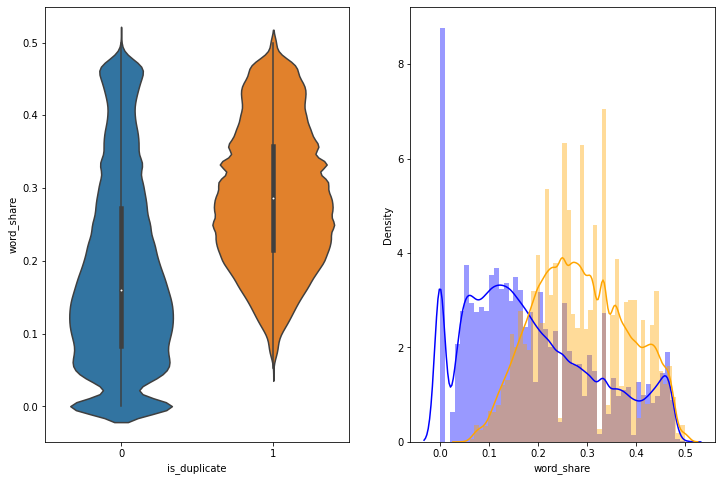

In [83]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==0]['word_share'][0:],label="0",color="blue")
sns.distplot(df[df['is_duplicate']==1]['word_share'][0:],label="1",color="orange")

plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

**Feature: word_common**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



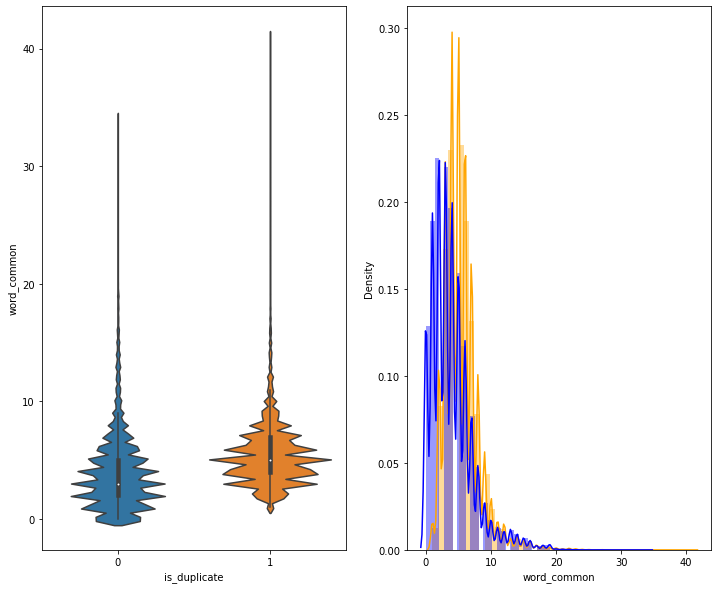

In [89]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'orange')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

# **Pre-processing of text**

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

Function to Compute and get the features : With 2 parameters of Question 1 and Question 2:

In [107]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_features_without_preprocessing.csv'):
    df = pd.read_csv("df_features_without_preprocessing.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_features_without_preprocessing.csv from drive or run the code above")

In [97]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

##**Advanced Feature Extraction (NLP and Fuzzy Features)**

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [110]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # Refer here:
    # http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [112]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")           #train file=quora.csv
    df = pd.read_csv("quora.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


## **Analysis of extracted features**

Plotting word-cloud

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [114]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [117]:
# reading the text files and removing the Stop Words:
from os import path
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


Word Clouds generated from duplicate pair question's text 

Word Cloud for Duplicate Question pairs


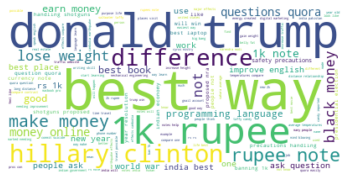

In [118]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Clouds generated from non-duplicate pair question's text

Word Cloud for non-Duplicate Question pairs:


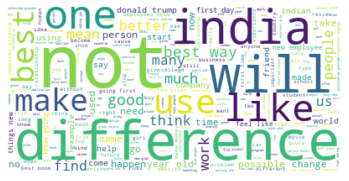

In [119]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

- In the word-clouds plotted above we can see that there are some magnified words which occur more frequently in Duplicate question pairs but not in non-duplicate question pairs and vice-versa. It gives us the intuition to obtain text features. 

Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

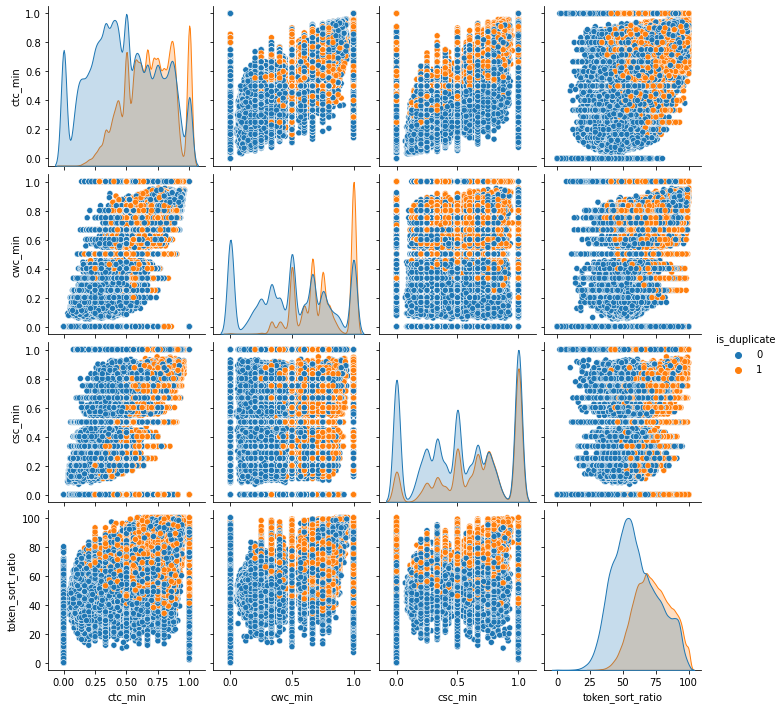

In [120]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

- In the pairplot we can observe the overlapping between the two categories based on the plotted features. Also there exist some space in the plots where exist only one kind of data points. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



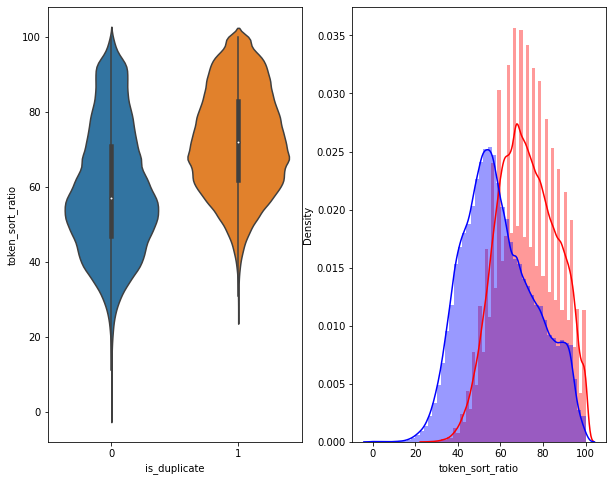

In [121]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



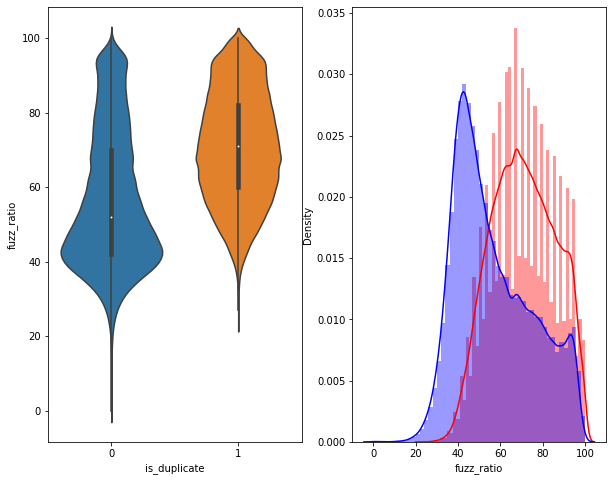

In [122]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## **Visualization**

In [123]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
# Normalize using MinMaxScaler - default range: [0,1]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [124]:
tsne2d = TSNE(
    n_components=2,
    random_state=101,
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.264s
[t-SNE] Iteration 50: error = 80.9754486, gradient norm = 0.0432390 (50 iterations in 2.504s)
[t-SNE] Iteration 100: error = 70.4374771, gradient norm = 0.0093234 (50 iterations in 1.777s)
[t-SNE] Iteration 150: error = 68.6510849, gradient norm = 0.0054945 (50 iterations in 1.755s)
[t-SNE] Iteration 200: error = 67.7990570, gradient norm = 0.0052081 (50 iterations in 1.834s)
[t-SNE] Iteration 250: error = 67.3016968, gradient norm = 0.0034786

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



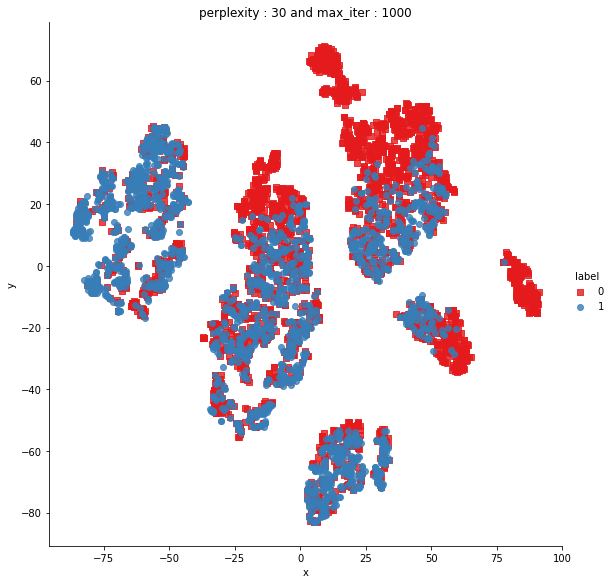

In [125]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

- We can clearly observe that there are both overlapped and unoverlapped datapoints while we representes the generated feature in 2-D

## Featurizing text data with tfidf weighted word-vectors

In [131]:
# avoid decoding problems
df = pd.read_csv("quora.csv")


df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(df['question1']):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

In [ ]:
vecs2 = []
for qu2 in list(df['question2']):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [135]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous section of notebook")

if os.path.isfile('df_features_without_preprocessing.csv'):
    dfppro = pd.read_csv("df_features_without_preprocessing.csv",encoding='latin-1')
else:
    print("download df_features_without_preprocessing.csv from drive or run previous section of notebook")

In [136]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [ ]:
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [137]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

# **Machine Learning Models**

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [156]:
!pip install -U scikit-learn

In [166]:
data=pd.read_csv("final_features.csv",nrows=10000)

In [167]:
data

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,38.575120,...,-14.608611,-14.153514,-29.568828,29.144799,41.087017,-6.711498,-8.812467,7.906522,-27.432420,10.599943,16.952886,-15.785523,-18.361750,-23.125756,-7.145598,-15.993189,-0.493609,3.726502,25.448065,16.128444,-27.806874,-2.436932,5.134369,-8.074996,24.421846,8.739254,-17.285154,13.440285,-13.209145,1.079919,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,-79.721632,...,-1.663620,-0.402938,-14.087219,38.538202,9.727834,13.917810,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.296450,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.568080,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,52.444493,...,-8.954575,-15.803814,-5.150883,17.270690,14.479286,-8.041332,-37.765046,8.256755,-37.232596,0.989206,11.408972,-3.191425,-12.339837,-24.161270,-10.353968,-28.326909,-12.874845,6.732092,8.607652,0.745432,-25.891975,-9.892551,-6.407806,-1.322369,15.972339,17.672533,-9.950780,0.094202,-13.221513,-14.747519,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,-62.898284,...,-11.371908,-3.578342,-2.376237,20.909671,3.221330,-8.993710,-12.933957,0.584045,-15.961217,2.370193,9.618801,5.654456,-4.039893,-19.908457,-11.321396,-24.859472,-13.069850,9.953773,-1.694113,4.442514,-9.278886,-3.784161,8.152649,7.866912,8.705768,8.401290,-3.039061,10.259952,-8.754181,-7.158578,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,203.339632,...,-11.345449,6.101218,-23.438455,24.105925,10.318461,-0.063605,-1.480551,6.154874,-14.630949,19.905604,2.042963,-3.555425,-1.255108,-8.036084,-9.766769,-16.191164,-8.790663,4.519232,12.908963,10.736240,-24.625240,-19.771682,7.144672,8.497629,17.803612,5.478965,-10.447376,6.479129,-2.375045,-5.082603,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [168]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [169]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,38.575120,-27.622444,-21.129949,-44.072655,...,-14.608611,-14.153514,-29.568828,29.144799,41.087017,-6.711498,-8.812467,7.906522,-27.432420,10.599943,16.952886,-15.785523,-18.361750,-23.125756,-7.145598,-15.993189,-0.493609,3.726502,25.448065,16.128444,-27.806874,-2.436932,5.134369,-8.074996,24.421846,8.739254,-17.285154,13.440285,-13.209145,1.079919,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,-79.721632,25.818640,-7.883405,-124.308125,...,-1.663620,-0.402938,-14.087219,38.538202,9.727834,13.917810,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.296450,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.568080,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,52.444493,-45.197928,74.042597,-35.915018,...,-8.954575,-15.803814,-5.150883,17.270690,14.479286,-8.041332,-37.765046,8.256755,-37.232596,0.989206,11.408972,-3.191425,-12.339837,-24.161270,-10.353968,-28.326909,-12.874845,6.732092,8.607652,0.745432,-25.891975,-9.892551,-6.407806,-1.322369,15.972339,17.672533,-9.950780,0.094202,-13.221513,-14.747519,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,-62.898284,-94.979633,24.331771,37.013586,...,-11.371908,-3.578342,-2.376237,20.909671,3.221330,-8.993710,-12.933957,0.584045,-15.961217,2.370193,9.618801,5.654456,-4.039893,-19.908457,-11.321396,-24.859472,-13.069850,9.953773,-1.694113,4.442514,-9.278886,-3.784161,8.152649,7.866912,8.705768,8.401290,-3.039061,10.259952,-8.754181,-7.158578,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,203.339632,-160.598199,7.764019,14.426265,...,-11.345449,6.101218,-23.438455,24.105925,10.318461,-0.063605,-1.480551,6.154874,-14.630949,19.905604,2.042963,-3.555425,-1.255108,-8.036084,-9.766769,-16.191164,-8.790663,4.519232,12.908963,10.736240,-24.625240,-19.771682,7.144672,8.497629,17.803612,5.478965,-10.447376,6.479129,-2.375045,-5.082603,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.47868

## Random train test split( 70:30)

In [170]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [171]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 794)
Number of data points in test data : (3000, 794)


In [172]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

##**Building a random model (Finding worst-case log-loss)**

Log loss on Test Data using Random Model 0.8831132400707369


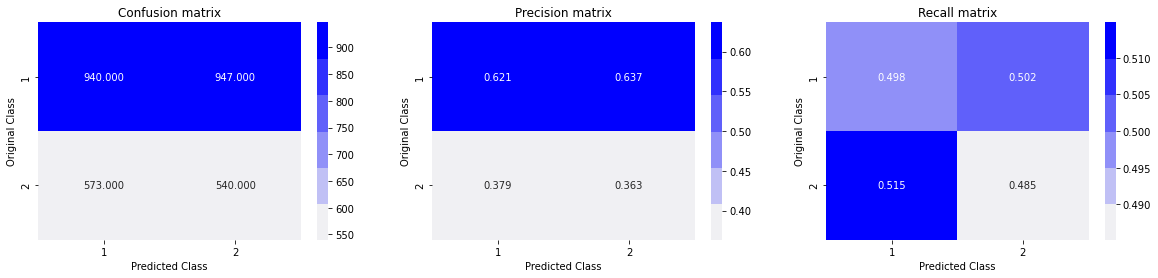

In [173]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## **Logistic regression with hyperparameter tuning**

For values of alpha =  1e-05 The log loss is: 0.6594859818900423
For values of alpha =  0.0001 The log loss is: 0.6594859818900423
For values of alpha =  0.001 The log loss is: 0.5125918346444013
For values of alpha =  0.01 The log loss is: 0.5153200244654991
For values of alpha =  0.1 The log loss is: 0.5169448612690888
For values of alpha =  1 The log loss is: 0.5147649904209041
For values of alpha =  10 The log loss is: 0.5263035456140881


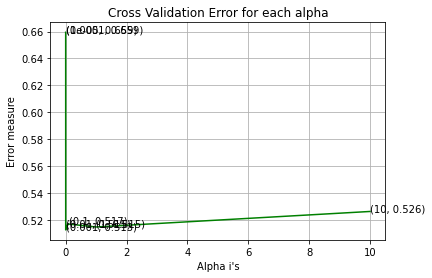

For values of best alpha =  0.001 The train log loss is: 0.47550949564902006
For values of best alpha =  0.001 The test log loss is: 0.5125918346444013
Total number of data points : 3000


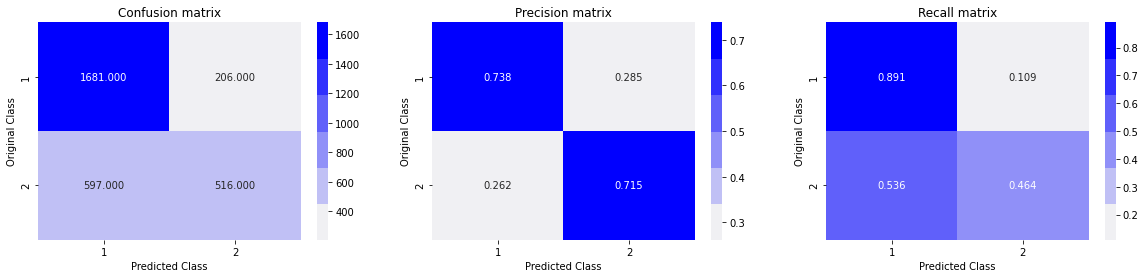

In [174]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## **Linear SVM with hyperparameter tuning**

For values of alpha =  1e-05 The log loss is: 0.6594859818900423
For values of alpha =  0.0001 The log loss is: 0.6594859818900423
For values of alpha =  0.001 The log loss is: 0.6594859818900423
For values of alpha =  0.01 The log loss is: 0.6594859818900423
For values of alpha =  0.1 The log loss is: 0.6594859818900423
For values of alpha =  1 The log loss is: 0.6594859818900423
For values of alpha =  10 The log loss is: 0.6594859818900423


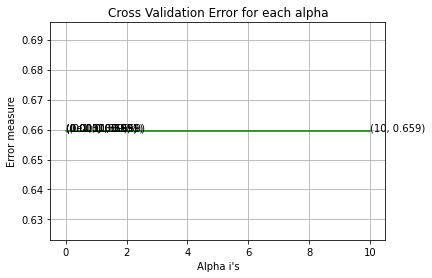

For values of best alpha =  1e-05 The train log loss is: 0.6595612003985919
For values of best alpha =  1e-05 The test log loss is: 0.6594859818900423
Total number of data points : 3000


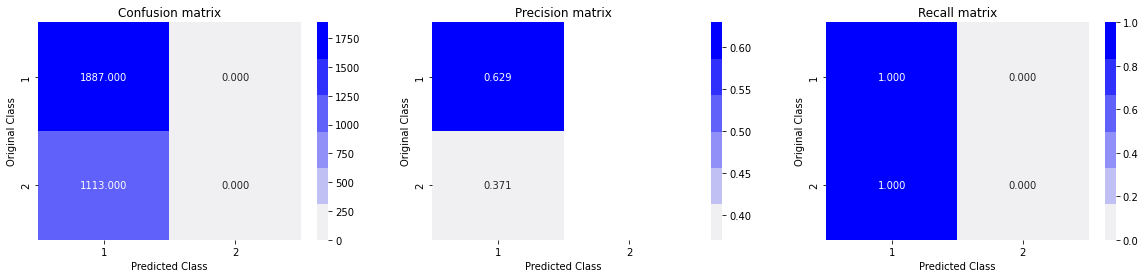

In [175]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##**XGBoost**

In [176]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684573	valid-logloss:0.684706
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614139	valid-logloss:0.615537
[20]	train-logloss:0.562371	valid-logloss:0.565072
[30]	train-logloss:0.523727	valid-logloss:0.527728
[40]	train-logloss:0.493254	valid-logloss:0.4984
[50]	train-logloss:0.469281	valid-logloss:0.475428
[60]	train-logloss:0.450221	valid-logloss:0.457203
[70]	train-logloss:0.434767	valid-logloss:0.442991
[80]	train-logloss:0.421814	valid-logloss:0.431378
[90]	train-logloss:0.411133	valid-logloss:0.421687
[100]	train-logloss:0.401987	valid-logloss:0.413851
[110]	train-logloss:0.394392	valid-logloss:0.407498
[120]	train-logloss:0.387409	valid-logloss:0.40189
[130]	train-logloss:0.381192	valid-logloss:0.397272
[140]	train-logloss:0.3756	valid-logloss:0.393709
[150]	train-logloss:0.370634	valid-logloss:0.390313
[160]	train-logloss:0.365793	vali

Total number of data points : 3000


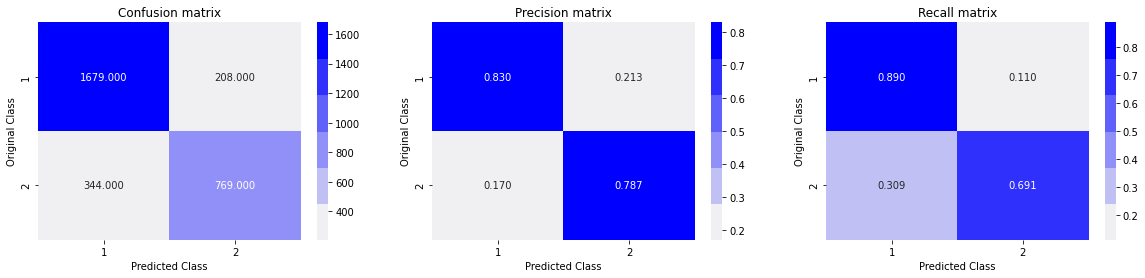

In [177]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#**Conclusion**

- Logistic Regrerssion: </br>
train log loss is: 0.47550949564902006
test log loss is: 0.5125918346444013</br>

which is quite better and much better than a random model.</br>

class 1 precision score: 0.738</br>
class 2 precision score: 0.715

class 1 recall score: 0.891</br>
class 2 recall score: 0.464 (high biased)

Here the point of concern is the recall score of class 2.

- Linear SVM:</br>
train log loss is: 0.6595612003985919</br>
test log loss is: 0.6594859818900423

On test data it has predicted every data point as class 1, which means it is heavily biased.

- XGBoost:</br>
train-logloss:0.684573	</br>
test log loss is: 0.3672695881959129

class 1 precision score: 0.830</br>
class 2 precision score: 0.787

class 1 recall score: 0.890</br>
class 2 recall score: 0.691
 